In [60]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import math

## Data cleaning

The following cells will improve the DF, which presents inconsistency, missing values and outliers, thanks to consideration done during the data understanding phase

In [61]:
# load df
df = pd.read_csv("../dataset/customer_supermarket_regex.csv", index_col=0, parse_dates=["BasketDate"], decimal=",")
df.Sale = df.Sale.astype(float)

In [62]:
#delete every row with Qta <= 0
print("DF len before deleting rows with Qta  <= 0", len(df))
df = df[df['Qta'] > 0]
print("DF len after deleting rows with Qta  <= 0", len(df))

DF len before deleting rows with Qta  <= 0 396687
DF len after deleting rows with Qta  <= 0 387881


In [63]:
# inconsistency resolution

def inconsistency_resolver(path,col1,col2):
    
    with open(path, 'r') as f:
        inconsistent_list = json.load(f)
        
    df_inconsistent = df[df[col1].isin(inconsistent_list)]

    df_grouped = df_inconsistent.groupby([col1,col2]).size().reset_index()
    
    df_grouped = df_grouped.sort_values(0, ascending=False).drop_duplicates(col1).sort_index()
    
    mydict = pd.Series(df_grouped[col2].values,index=df_grouped[col1]).to_dict()
    
    for k,v in mydict.items():
        
        df.loc[df[col1] == k, col2] = v

inconsistency_resolver("../dataset/inconsistent_CustomerID_CustomerCountry.json","CustomerID","CustomerCountry") 
inconsistency_resolver("../dataset/inconsistent_ProdID_ProdDescr.json","ProdID","ProdDescr") 

In [64]:
''' check if inconsistency has been solved
def inconsistent_set(K,V):
    
    inconsistentset = list()

    for key in df[K].unique().tolist():
        temp_df = df[df[K] == key]
        valueslist = temp_df[V].tolist()
        for value in valueslist:
            if(valueslist[0] != value):
                inconsistentset.append(key)
                break;
    return inconsistentset


# 1
ProdID_ProdDescr_IS = inconsistent_set("ProdID","ProdDescr")
            
print("Number of not consistent ProdDescr:", len(ProdID_ProdDescr_IS))

#3 
CustomerID_CustomerCountry_IS = inconsistent_set("CustomerID","CustomerCountry")
            
print("Number of not consistent CustomerCountry:", len(CustomerID_CustomerCountry_IS))
'''

' check if inconsistency has been solved\ndef inconsistent_set(K,V):\n    \n    inconsistentset = list()\n\n    for key in df[K].unique().tolist():\n        temp_df = df[df[K] == key]\n        valueslist = temp_df[V].tolist()\n        for value in valueslist:\n            if(valueslist[0] != value):\n                inconsistentset.append(key)\n                break;\n    return inconsistentset\n\n\n# 1\nProdID_ProdDescr_IS = inconsistent_set("ProdID","ProdDescr")\n            \nprint("Number of not consistent ProdDescr:", len(ProdID_ProdDescr_IS))\n\n#3 \nCustomerID_CustomerCountry_IS = inconsistent_set("CustomerID","CustomerCountry")\n            \nprint("Number of not consistent CustomerCountry:", len(CustomerID_CustomerCountry_IS))\n'

## Data recovery

Some rows from the initial database were partially completed, there were missing values. We want to recover these rows by checking if there are rows with missing values that are very close to rows without partial data.

The result of the following cell is negative, we can't recovery the partial rows.

In [65]:
''' uncomment to check if there are similar rows. (there aren't similar rows)
def similar_rows(basketID, basketDate):
    
    for i in tqdm(range(len(basketID))):
        temp_df = df[(df['BasketID'] == basketID[i]) & (df['BasketDate'] == basketDate[i])]
        if(len(temp_df) > 0):
            print(temp_df)
    
    
    
df_nan = pd.read_csv("../dataset/customer_supermarket_nan.csv", sep="\t", index_col=0, decimal=",")
print("Number of rows with nan values", len(df_nan))

#df_nan['CustomerID'] = df[df['BasketID'] == df_nan['BasketID']][0]['CustomerID']
similar_rows(df_nan.BasketID.values,df_nan.BasketDate.values)

is_NaN = df_nan.isnull()
row_has_NaN = is_NaN.any(axis=1)
print("Number of rows with nan values after matching partial rows with complete rows", len(df_nan[row_has_NaN]))
'''

#duplicates_free = df_nan.drop_duplicates(subset=['BasketID','BasketDate','CustomerCountry','ProdID'])
#only_duplicates = df_nan[np.invert(df_nan.index.isin(duplicates_free.index))]
#df_nan_group = df_nan.groupby(['BasketID','BasketDate','CustomerCountry','ProdID']).size()

#df_nan['CustomerID'] = df[df['BasketID'] == df_nan['BasketID'] & df['BasketDate'] == df_nan['BasketDate'] & df['CustomerCountry'] == df_nan['CustomerCountry']]['CustomerID']

' uncomment to check if there are similar rows. (there aren\'t similar rows)\ndef similar_rows(basketID, basketDate):\n    \n    for i in tqdm(range(len(basketID))):\n        temp_df = df[(df[\'BasketID\'] == basketID[i]) & (df[\'BasketDate\'] == basketDate[i])]\n        if(len(temp_df) > 0):\n            print(temp_df)\n    \n    \n    \ndf_nan = pd.read_csv("../dataset/customer_supermarket_nan.csv", sep="\t", index_col=0, decimal=",")\nprint("Number of rows with nan values", len(df_nan))\n\n#df_nan[\'CustomerID\'] = df[df[\'BasketID\'] == df_nan[\'BasketID\']][0][\'CustomerID\']\nsimilar_rows(df_nan.BasketID.values,df_nan.BasketDate.values)\n\nis_NaN = df_nan.isnull()\nrow_has_NaN = is_NaN.any(axis=1)\nprint("Number of rows with nan values after matching partial rows with complete rows", len(df_nan[row_has_NaN]))\n'

DF without inconsistency serialization

In [66]:
df.to_csv("../dataset/customer_supermarket_no_inconsistency.csv", sep="\t", decimal=",")

## Indicators

In [67]:
# first of all we deserialize our dataframe
df = pd.read_csv("../dataset/customer_supermarket_no_inconsistency.csv", sep="\t", index_col=0, parse_dates=["BasketDate"], decimal=",")
# second remove outliers from df
df = df[df['Outlier'] == False]
print(df.head())
print(df.info())

   BasketID          BasketDate  ProdID  Qta  Sale  CustomerID  \
0    536365 2010-01-12 08:26:00   21730    6  4.25       17850   
1    536365 2010-01-12 08:26:00   22752    2  7.65       17850   
2    536365 2010-01-12 08:26:00   71053    6  3.39       17850   
3    536365 2010-01-12 08:26:00  84029E    6  3.39       17850   
4    536365 2010-01-12 08:26:00  84029G    6  3.39       17850   

  CustomerCountry                            ProdDescr  Outlier  
0  United Kingdom    GLASS STAR FROSTED T-LIGHT HOLDER    False  
1  United Kingdom         SET 7 BABUSHKA NESTING BOXES    False  
2  United Kingdom                  WHITE METAL LANTERN    False  
3  United Kingdom       RED WOOLLY HOTTIE WHITE HEART.    False  
4  United Kingdom  KNITTED UNION FLAG HOT WATER BOTTLE    False  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 387641 entries, 0 to 387880
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   ----

# I - indicator
the total number of items purchased by a customer during the period of
observation.

In [68]:
df_i = df.groupby("CustomerID").sum().reset_index()
df_i = df_i[["CustomerID", "Qta"]]
df_i

,CustomerID,Qta
0,12347,2458
1,12348,2341
2,12349,630
3,12350,197
4,12352,533
...,...,...
4321,18280,45
4322,18281,54
4323,18282,103
4324,18283,1357


In [69]:
df_i.sort_values(by='Qta', ascending=False)

,CustomerID,Qta
1686,14646,188323
1876,14911,80488
54,12415,75557
3762,17511,64549
4190,18102,60164
...,...,...
3477,17102,2
2867,16257,2
4312,18268,2
2552,15823,1


In [70]:
#!! look at this, it might be an outlier
print(df[df.CustomerID == 14646])

        BasketID          BasketDate ProdID  Qta  Sale  CustomerID  \
23611     539491 2010-12-20 10:09:00  20751    1  2.10       14646   
23612     539491 2010-12-20 10:09:00  21123    2  1.25       14646   
23613     539491 2010-12-20 10:09:00  21246    2  4.95       14646   
23614     539491 2010-12-20 10:09:00  21931    1  1.95       14646   
23615     539491 2010-12-20 10:09:00  21981   12  0.29       14646   
...          ...                 ...    ...  ...   ...         ...   
384485    581176 2011-07-12 15:19:00  22907   96  0.72       14646   
384486    581176 2011-07-12 15:19:00  22908   96  0.72       14646   
384487    581176 2011-07-12 15:19:00  23112   12  6.65       14646   
384488    581176 2011-07-12 15:19:00  23118   16  6.65       14646   
385531    581338 2011-08-12 12:12:00  23344  140  1.79       14646   

       CustomerCountry                            ProdDescr  Outlier  
23611      Netherlands     FUNKY WASHING UP GLOVES ASSORTED    False  
23612      Nether

# Iu - indicator
the number of distinct items bought by a customer in the period of
observation.

In [71]:
df_iu = df.groupby('CustomerID')['ProdID'].nunique().reset_index()
df_iu

,CustomerID,ProdID
0,12347,103
1,12348,22
2,12349,72
3,12350,17
4,12352,58
...,...,...
4321,18280,10
4322,18281,7
4323,18282,12
4324,18283,263


# Imax - indicator
the maximum number of items purchased by a customer during a
shopping session

In [72]:
df_imax = df.groupby(["CustomerID", "BasketID"]).Qta.sum()
df_imax = df_imax.groupby(level=0).head(1).reset_index()

#df_imax = df_imax.max(level=0)

df_imax

,CustomerID,BasketID,Qta
0,12347,537626,319
1,12348,539318,1254
2,12349,577609,630
3,12350,543037,197
4,12352,544156,98
...,...,...,...
4321,18280,545712,45
4322,18281,556464,54
4323,18282,562525,75
4324,18283,540350,61


# E - indicator
the Shannon entropy on the purchasing behaviour of the customer

In [73]:
df_temp = df.groupby(["CustomerID", "BasketID"]).Qta.sum().reset_index()
values = df_temp["Qta"]
df_temp['Entropy'] = -(values*np.log(values))
df_entropy = df_temp.groupby('CustomerID')['Entropy'].sum().reset_index()
# to remove nan values caused by logs
df_entropy['Entropy'] = df_entropy['Entropy'].fillna(0)


df_entropy

,CustomerID,Entropy
0,12347,-14642.853340
1,12348,-15464.124169
2,12349,-4060.803486
3,12350,-1040.791135
4,12352,-2359.276847
...,...,...
4321,18280,-171.299812
4322,18281,-215.405139
4323,18282,-417.113335
4324,18283,-6354.286026


### Putting together all indicators

In [74]:
frames = [df_entropy, df_imax.Qta, df_iu.ProdID, df_i.Qta]
indicators = pd.concat(frames, join='outer', axis=1)
indicators.columns = ("CustomerID", "Entropy", "imax", "iu", "i")
print(indicators.head())

indicators.to_csv("../dataset/indicators.csv")

   CustomerID       Entropy  imax   iu     i
0       12347 -14642.853340   319  103  2458
1       12348 -15464.124169  1254   22  2341
2       12349  -4060.803486   630   72   630
3       12350  -1040.791135   197   17   197
4       12352  -2359.276847    98   58   533


# Additional indicators

### Customer Spending Profile 
we categorize each customer as either low, medium, or high spending according to their average expense

range(0, 1050, 50)


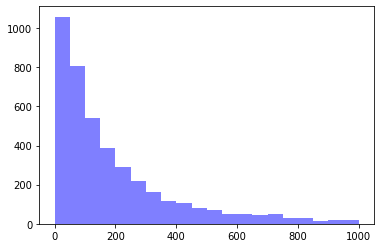

CustomerID
12347      high
12348    medium
12349      high
12350       low
12352      high
          ...  
18280       low
18281       low
18282       low
18283      high
18287    medium
Name: Sale, Length: 4326, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

In [75]:
df_profile = df.groupby(["CustomerID"]).agg({"Sale":sum, "Qta":sum})

binwidth = 50
bins=range(0, 1000 + binwidth, binwidth)
print(bins)
n, bins, patches = plt.hist(df_profile.Sale, bins=bins, facecolor='blue', alpha=0.5)
plt.show()

spending_profile = pd.cut(df_profile['Sale'], bins=[0, 100, 300, df_profile.Sale.max()], include_lowest=True, labels=["low", "medium", "high"])
spending_profile

### The average cost of a basket

range(0, 450, 50)


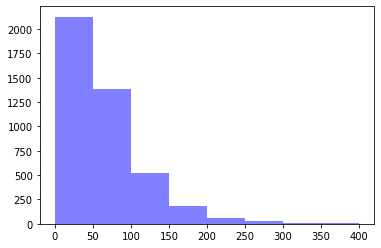

CustomerID
12347    medium
12348       low
12349      high
12350    medium
12352    medium
          ...  
18280       low
18281       low
18282       low
18283    medium
18287       low
Name: Sale, Length: 4326, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

In [76]:
df_customer_basket_groupby_sum = df.groupby(["CustomerID",'BasketID'], as_index=False).agg({"Sale":sum})

series_customer_basket_groupby_mean = df_customer_basket_groupby_sum.groupby('CustomerID')['Sale'].mean()
df_customer_basket_groupby_mean = pd.DataFrame(df_customer_basket_groupby_mean)

binwidth = 50
bins=range(0, 400 + binwidth, binwidth)
print(bins)
n, bins, patches = plt.hist(df_customer_basket_groupby_mean.Sale, bins=bins, facecolor='blue', alpha=0.5)
plt.show()

basket_cost_profile = pd.cut(df_customer_basket_groupby_mean['Sale'], bins=[0, 50, 200, df_customer_basket_groupby_mean.Sale.max()], include_lowest=True, labels=["low", "medium", "high"])
basket_cost_profile

### Sales per country
(is this even an indicator?)

In [77]:
df_sales_per_country = df.groupby(["CustomerCountry"])["Sale"].sum().reset_index()
print(df_sales_per_country)

         CustomerCountry           Sale
0              Australia    3253.410000
1                Austria    1693.900000
2                Bahrain      78.950000
3                Belgium    7372.850000
4                 Brazil     142.600000
5                 Canada     359.640000
6        Channel Islands    3095.000000
7                 Cyprus    3145.460000
8         Czech Republic      78.270000
9                Denmark    1195.550000
10                  EIRE   28760.040000
11    European Community     289.800000
12               Finland    3352.840000
13                France   27346.770000
14               Germany   30270.790000
15                Greece     663.290000
16               Iceland     481.210000
17                Israel     898.590000
18                 Italy    3276.210000
19                 Japan     651.080000
20               Lebanon     242.440000
21             Lithuania      99.440000
22                 Malta     545.190000
23           Netherlands    6240.850000


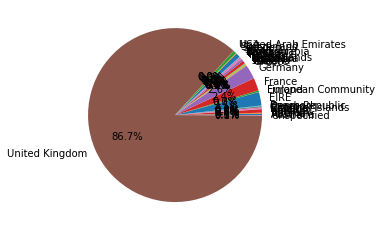

In [78]:
# the pie plot is horrible because of england, that probably has some outliers
#explode=np.zeros(len(df_sales_per_country.CustomerCountry))

plt.pie(df_sales_per_country.Sale, labels=df_sales_per_country.CustomerCountry, autopct='%1.1f%%')
plt.show()

### Most bought items

In [79]:
cols_dropped = [2, 3, 6]
df_most_bought = df.groupby(["ProdID", "ProdDescr"]).sum().reset_index()
#df_most_bought = df_most_bought.drop(df_most_bought.columns[cols_dropped], axis=1)
df_most_bought = df_most_bought.sort_values(by="Qta", ascending=False)
#df_most_bought = df_most_bought.groupby(level=0).head(1).reset_index()
df_most_bought 

#print(df[df.ProdDescr == "Discount"])

,ProdID,ProdDescr,BasketID,Qta,Sale,CustomerID,Outlier
3217,85099B,JUMBO BAG RED RETROSPOT,893874571,42878,3250.56,24412182,0
1088,22197,POPCORN HOLDER,576233724,35268,883.80,15843335,0
2802,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,258666735,34351,135.83,7039020,0
3231,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1098920835,30901,5840.68,30691264,0
3057,84879,ASSORTED COLOUR BIRD ORNAMENT,767400468,30215,2340.24,20893961,0
...,...,...,...,...,...,...,...
2415,35597B,BLACKCHRISTMAS TREE 30CM,537335,1,1.25,15048,0
2414,35597A,DUSTY PINK CHRISTMAS TREE 30CM,537335,1,1.25,15048,0
3403,90039C,FIRE POLISHED GLASS BRACELET BLACK,543535,1,3.75,17537,0
2404,35004P,SET OF 3 PINK FLYING DUCKS,538307,1,5.45,14667,0


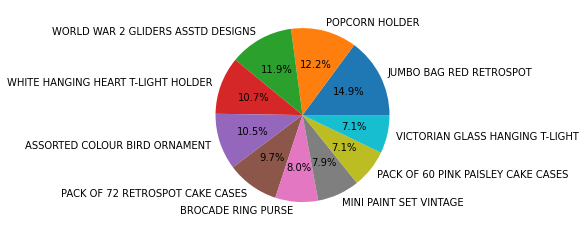

In [80]:
plt.pie(df_most_bought[:10].Qta, labels=df_most_bought[:10].ProdDescr, autopct='%1.1f%%')
plt.savefig("../output/most_bought_item_piechart.png")
plt.show()

### Most bought item per country


In [81]:
#cols_dropped = [3, 4, 7]
df_mb_country = df.groupby(["ProdID", "ProdDescr", "CustomerCountry"]).sum().reset_index()
df_mb_country = df_mb_country.drop(["Sale"], axis = 1)

df_mb_country = df_mb_country[df_mb_country.groupby(["CustomerCountry"])["Qta"].transform("max") == df_mb_country["Qta"]].reset_index()

#df_mb_country = df_mb_country.groupby(["CustomerCountry"]).agg({"Qta" : "max"}).reset_index()
#print(df_mb_country.CustomerCountry.unique())


print(df_mb_country)


    index  ProdID                            ProdDescr       CustomerCountry  \
0     135   16008  SMALL FOLDING SCISSOR(POINTED EDGE)                Norway   
1     661   20719               WOODLAND CHARLOTTE BAG                Israel   
2    1966   21212      PACK OF 72 RETROSPOT CAKE CASES               Belgium   
3    2100   21232       STRAWBERRY CERAMIC TRINKET BOX                Poland   
4    2677   21430   SET/3 RED GINGHAM ROSE STORAGE BOX                Brazil   
..    ...     ...                                  ...                   ...   
57  17625  84971S            SMALL HEART FLOWERS HOOK                 Brazil   
58  17770  84997D      CHILDRENS CUTLERY POLKADOT PINK               Finland   
59  17780  84997D      CHILDRENS CUTLERY POLKADOT PINK                 Spain   
60  18102  85099B              JUMBO BAG RED RETROSPOT        United Kingdom   
61  18418   85215       ASSORTED CHEESE FRIDGE MAGNETS  United Arab Emirates   

     BasketID    Qta  CustomerID  Outli

### Linear Graphs

In [82]:
# start and end datetimes
print(df.BasketDate.min(), df.BasketDate.max())

2010-01-12 08:26:00 2011-12-10 17:19:00


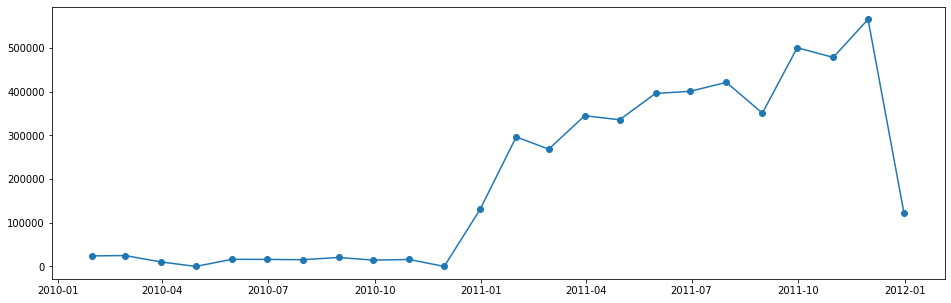

In [83]:
weekly = df.set_index("BasketDate").copy()
weekly = weekly.groupby(pd.Grouper(freq='M'))["Qta"].sum()

#print(weekly)

plt.figure(figsize=(16,5))
plt.plot(weekly.index, weekly, color='tab:blue', marker="o")